<a href="https://colab.research.google.com/github/eyalgur1/AutoEncoders/blob/main/AutoEncoder_CNN_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [95]:
import torch
from torch import nn, optim
from torch.optim import Optimizer
import torchvision
import torchvision.transforms as transforms
import random
import pdb  # for debugging
import matplotlib.pyplot as plt
import numpy as np

In [96]:
# Hyperparameters for CIFAR10 training set (set by the user)
# Note: CIFAR10 training set contains 50000 images

batch_size = 125  # batch_size=125 is divisable by 50000 (division is not necessary, but better for plotting)
shuffle = True  # shuffle the training set
seed = random.randint(0, 100)  # set seed for reproducibility

In [97]:
# Hyperparmeters for training of models (set by the user)
# Joint Model: a standard ADAM optimizer model that updates all weights in every iteration.
# NAM Model: updates the encoder and the decoder in an alternating fashion using ADAM.


# Note 1:
# In the current implementation of NAM, the update of the encoder and decoder switches at the end of each epoch.
# This means that after completing an epoch, the next epoch begins with the update of the other one (hence, in a single epoch only one of them is updated).
# This switching strategy can be modified; for instance, they can switch roles within each mini-batch.
# In this alternative approach, the decoder would be trained on a mini-batch, and then the encoder update would switch for the same mini-batch.


# Note 2:
# The implementation of all models below allows to set a maximal number of iterations for the epochs.
# Recall that one iteraion corresponds to a single batch, hence the maximal possible number of iterations at each epoch is len(trainloader.dataset)//batch_size.
# This means that by limiting the number ot iterations for an epochs, implies that not all batches will be considered for this epoch.


num_epochs = 8
joint_model = True  # Set True for Joint Model training
NAM_model = True  # Set True for NAM Model training
decoder_start = True  # if decoder_start=True, NAM starts with decoder updates, else encoder updates (required for if NAM_model=True); See Note 1 above
lr_joint = 0.001  # lr for Joint Model (set 0.001 for ADAM's default)
lr_decoder, lr_encoder = (0.01, 0.0001)  # lr for NAM Model's decoder/encoder update (set 0.001 for ADAM's default)
num_iter_joint = 'max'  # 'max' or inetger lower than 'max' (otherwise it is set automatically to 'max'); limiting the number of iterations of the epochs of the Joint Model; See Note 2 above
num_iter_decoder, num_iter_encoder = ('max', 'max')  # 'max' or inetger lower than 'max' (otherwise it set automatically to 'max'); limiting the number of iterations of the epochs of the NAM Model; See Note 2 above

In [98]:
# Define an AutoEncoder for 3×32×32 CIFAR10 photos


class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 12, 4, stride=2, padding=1),  # Takes input shape [batch, channel=3, H=32, W=32] and transforms it to [batch, 12, 16, 16]
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),  # [batch, 24, 8, 8]
            nn.ReLU(),
			nn.Conv2d(24, 48, 4, stride=2, padding=1),  # [batch, 48, 4, 4]
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
			nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1),  # Takes input shape [batch, channel=48, H=4, W=4] and transforms it to [batch, 12, 16, 16]
            nn.ReLU(),
			nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1),  # [batch, 12, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),  # [batch, 3, 32, 32]
            nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 3, 32, 32)  # reshape to original image size
        return decoded

In [99]:
# Auxiliary functions

def set_seed(seed):  # set seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


def switch_requires_grad(model, decoder):  # switch requires_grad for model object containing encoder and decoder
    if decoder:
        for param in model.decoder.parameters():
            param.requires_grad = True
        for param in model.encoder.parameters():
            param.requires_grad = False
    else:
        for param in model.encoder.parameters():
            param.requires_grad = True
        for param in model.decoder.parameters():
            param.requires_grad = False


def reset_learning_rate(optimizer, lr):  # reset learning rate for optimizer object
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
# This function should be redefined to lr annealing.
# This function is currently unused below.


def NAM_epoch_iterations(decoder_update):  # sets the number of iterations for NAM Model epoch
    if decoder_update:  # this is a decoder epoch, so set decoder number of iterations
        num_iter_NAM = num_iter_decoder
    else:  # this is an encoder epoch, so set encoder number of iterations
        num_iter_NAM = num_iter_encoder
    return num_iter_NAM


def check_num_iter(num_iter_joint, num_iter_decoder, num_iter_encoder, num_iter):  # checks and sets the number of iterations for the epochs
    if (num_iter_joint == 'max') or (num_iter_joint > num_iter):
        num_iter_joint = num_iter
    if (num_iter_decoder == 'max') or (num_iter_decoder > num_iter):
        num_iter_decoder = num_iter
    if (num_iter_encoder == 'max') or (num_iter_encoder > num_iter):
        num_iter_encoder = num_iter
    return num_iter_joint, num_iter_decoder, num_iter_encoder

In [100]:
# Set training data (CIFAR10)
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=shuffle)

num_iter = int(len(trainloader.dataset)//batch_size)  # maximum number of iterations per epoch for plotting purposes as it is set automatically by PyTorch)
num_iter_joint, num_iter_decoder, num_iter_encoder = check_num_iter(num_iter_joint, num_iter_decoder, num_iter_encoder, num_iter)  # set the number of iterations for the epochs


# Set loss suitable for autoencoders
criterion = nn.MSELoss()

Files already downloaded and verified


In [101]:
# Training loop for Joint Model
if joint_model:  # train the Joint Model

    set_seed(seed)  # set seed for reproducibility
    model_joint = Autoencoder()
    optimizer = torch.optim.Adam(model_joint.parameters(), lr=lr_joint)  # optimizer for the Joint Model
    loss_joint = []  # loss container for the Joint Model

    print(f'\n Joint Model Training:')

    for epoch in range(num_epochs):
        for i, batch in enumerate(trainloader):  # for each batch and its index
            if i == num_iter_joint:  # limit the number of iterations of the epochs
                break
            inputs, _ = batch  # get the inputs (labels are not required for autoencoders)

            optimizer.zero_grad()  # clear the gradients of all autoencoder parameters
            outputs = model_joint(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()  # calculate partial_L/partial_w for all parameters
            optimizer.step()  # update step for all parameters
            loss_joint.append(loss.item())

        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


 Joint Model Training:
Epoch [1/8], Loss: 0.0153
Epoch [2/8], Loss: 0.0100
Epoch [3/8], Loss: 0.0074
Epoch [4/8], Loss: 0.0070
Epoch [5/8], Loss: 0.0064
Epoch [6/8], Loss: 0.0055
Epoch [7/8], Loss: 0.0053
Epoch [8/8], Loss: 0.0058


In [102]:
# Training loop for NAM Model
if NAM_model:

    set_seed(seed)  # set seed for reproducibility
    model_NAM = Autoencoder()
    optimizer_decoder = torch.optim.Adam(model_NAM.decoder.parameters(), lr=lr_decoder)  # decoder optimizer for NAM
    optimizer_encoder = torch.optim.Adam(model_NAM.encoder.parameters(), lr=lr_encoder)  # encoder optimizer for NAM
    loss_NAM = {}  # loss container for NAM Model
    iteration = 0  # total iteration counter (across epochs) for plotting purposes

    decoder_update = decoder_start  # switch between encoder and decoder (if decoder_update=Ture, then update decoder, else update encoder)
    num_iter_NAM = NAM_epoch_iterations(decoder_update)  # sets the number of iterations for the first epoch, according to whether the epoch corresponds to decoder/encoder

    # setting requires_grad=False for the non-updated parts could potentially save some computation by avoiding the calculation of gradients for those parameters.
    switch_requires_grad(model_NAM, decoder_update)  # switch requires_grad on and off according to the first epoch update (decoder and encoder)

    print(f'\n NAM Model Training:')

    for epoch in range(num_epochs):
        epoch_loss = []  # loss container for the epoch (this is required for easier plotting of decoder/encoder loss)
        epoch_iter = []  # total iteration container corresponding to the epoch (this is required for easier plotting of decoder/encoder loss)

        for i, data in enumerate(trainloader):  # for each batch and its index
            if i == num_iter_NAM:  # limit the number of iterations of the epochs
                break
            inputs, _ = data  # get the inputs (labels are not required for autoencoders)

            optimizer_decoder.zero_grad()  # clear the gradients of all decoder parameters
            optimizer_encoder.zero_grad()  # clear the gradients of all encoder parameters
            outputs = model_NAM(inputs)
            loss = criterion(outputs, inputs)
            loss.backward()  # calculate partial_L/partial_x for all parameters

            if decoder_update:
                optimizer_decoder.step()  # update step for decoder parameters
            else:
                optimizer_encoder.step()  # update step for encoder parameters

            epoch_loss.append(loss.item())
            epoch_iter.append(iteration)
            iteration += 1

        if decoder_update:
            print(f'Epoch [{epoch + 1}/{num_epochs}] (decoder), Loss: {loss.item():.4f}')
            loss_NAM[epoch] = (epoch_iter, epoch_loss, 'd')
        else:
            print(f'Epoch [{epoch + 1}/{num_epochs}] (encoder), Loss: {loss.item():.4f}')
            loss_NAM[epoch] = (epoch_iter, epoch_loss, 'e')

        decoder_update = not(decoder_update)  # switch between encoder and decoder
        switch_requires_grad(model_NAM, decoder_update)  # switch requires_grad on and off according to the next epoch update (decoder and encoder)
        num_iter_NAM = NAM_epoch_iterations(decoder_update)  # sets the number of iterations for the next epoch, according to whether the epoch corresponds to decoder/encoder


 NAM Model Training:
Epoch [1/8] (decoder), Loss: 0.0138
Epoch [2/8] (encoder), Loss: 0.0088
Epoch [3/8] (decoder), Loss: 0.0073
Epoch [4/8] (encoder), Loss: 0.0068
Epoch [5/8] (decoder), Loss: 0.0062
Epoch [6/8] (encoder), Loss: 0.0054
Epoch [7/8] (decoder), Loss: 0.0056
Epoch [8/8] (encoder), Loss: 0.0052


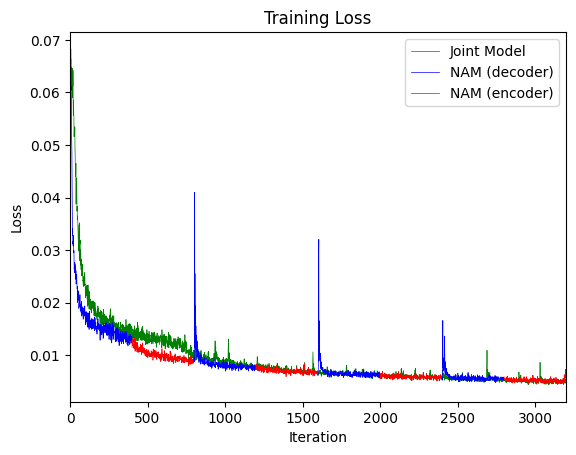

In [103]:
# Plotting the Loss


plot_joint_model = True
plot_NAM_model = True


if plot_joint_model:
    plt.plot(loss_joint, color='green', linewidth=0.5)


if plot_NAM_model:
    for epoch in range(num_epochs):
        if loss_NAM[epoch][2] == 'd':  # plot decoder iteration segments
            plt.plot(loss_NAM[epoch][0], loss_NAM[epoch][1], color='blue', linewidth = 0.5)
        else:  # plot encoder iteration segments
            plt.plot(loss_NAM[epoch][0], loss_NAM[epoch][1], color='red', linewidth = 0.5)


plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.xlim([0, num_epochs*num_iter])
plt.legend(['Joint Model', 'NAM (decoder)', 'NAM (encoder)'])
plt.show()